In [1]:
import pandas as pd
import numpy as np
import math
import os
from utils.utils import *
import matplotlib.pyplot as plt
import matplotlib
import random
import scipy as sc
import nibabel as nib

### Correlations between Cortical Surface and MDS positions

This notebook takes the distance between each voxel on the cortical surface (obtained using the meshes_and_distances.m matlab script, so run that first if you do not have the data saved) and on the MDS spaces (distances_mds.py) 

the correlation is ran a 1000 times with a set sample factor, and we take the median p values out of it

In [2]:
hemis = ['lh', 'rh']
upscaling_factor = 1.8**3
columns =  ['hemisphere', 
            'subject', 
            'roi', 
            'df', 
            'spearmanr',
            'pvalue']

rois_corr = {
    'V1': [1, 2],
    'V2v': [3],
    'V2d': [4],
    'V3v': [5],
    'V3d': [6],
    'hV4': [7],
    'VO-1': [8],
    'VO-2': [9],
    'PHC-1': [10],
    'PHC-2': [11],
    'LO-1': [12],
    'LO-2': [13],
    'TO-1': [14],
    'TO-2': [15]
}

types = ['string',
        'string',
        'string',
        'int',
        'float',
        'float',
         'float',
        'int', 
        'float',
        'int',
        'float']

significance = 0.05
scaling_factor = 1 / (1.8 ** 3)

In [30]:
rois_corr

{'V1': [1, 2],
 'V2v': [3],
 'V2d': [4],
 'V3v': [5],
 'V3d': [6],
 'hV4': [7],
 'VO-1': [8],
 'VO-2': [9],
 'PHC-1': [10],
 'PHC-2': [11],
 'LO-1': [12],
 'LO-2': [13],
 'TO-1': [14],
 'TO-2': [15]}

In [5]:
def work_spearman_downscaled(a, b, sample_size):
    #sample_size = round(a.shape[0] * factor)
    random_sample = random.sample(range(0, a.shape[0]), round(sample_size)) 
    sample_a = a[random_sample]
    sample_b = b[random_sample]
    results = sc.stats.spearmanr(sample_a, sample_b)
    return results.statistic, results.pvalue
def work_spearman_downscaled_averaged(a, b, sample_size, trials):
    rhos, p_values = [], []
    for i in range(trials):
        rho, p = work_spearman_downscaled(a, b, sample_size)
        rhos.append(rho)
        p_values.append(p)
    return np.median(np.asarray(rho)), np.median(np.asarray(p))

In [6]:
rois_corr_2 = {
    'V2': [3,4],
    'V3': [5,6],
}

In [8]:
roi_distances_mds = {}
roi_distances_cs = {}
model = 'oself'


distances_file = os.path.join(spatial_dir, f'distances_spearman_joined_{model}.npy')
if os.path.exists(distances_file):
    distances = np.load(distances_file, allow_pickle = True)
    distances = pd.DataFrame(distances, columns = columns)
    distances = distances.astype({c: t for c,t in zip(columns, types)})
else:
    distances = pd.DataFrame(np.zeros([len(subj_list) * 2 * len(rois_corr.keys()), len(columns)]), columns = columns)
    i = 0
    for sub in subj_list:
        if sub == 'subj06' or sub == 'subj08': 
            nan_mask_file = os.path.join(betas_dir, f"{sub}_betas_nans_mask.npy")
            nan_mask = np.load(nan_mask_file, allow_pickle=True)
        for hemi in hemis:
    
            for roi, pointer in rois_corr.items():

                if sub == 'subj06' or sub == 'subj08': 

                    mask_file = os.path.join(mask_dir, sub, f'{hemi}.short.{sub}.testrois.npy')
                    mask = np.load(mask_file, allow_pickle=True)
                    to_keep = np.isin(mask, pointer)
                    if hemi == 'lh':
                        current_roi_nans = nan_mask[:mask.shape[0]][to_keep]
                    if hemi == 'rh':
                        current_roi_nans = nan_mask[-mask.shape[0]:][to_keep]
                    roi_distances_cs_file = os.path.join(label_dir, 'freesurfer', sub,  'label', 'distances',   hemi + '.' + sub + '.dists_wrong.' + roi + '.mat')
                    roi_distances_cs = sc.io.loadmat(roi_distances_cs_file)['d_roi']
                    
                    if current_roi_nans is not None and False in current_roi_nans: 
                        roi_distances_cs = roi_distances_cs[current_roi_nans][:, current_roi_nans]

                else:
                    roi_distances_cs_file = os.path.join(label_dir, 'freesurfer', sub,  'label', 'distances',   hemi + '.' + sub + '.dists.' + roi + '.mat')
                    roi_distances_cs = sc.io.loadmat(roi_distances_cs_file)['d_roi']

                
                roi_distances_mds_file = os.path.join(dist_dir, sub,  hemi + '.' + model + '.' + sub + '.dists.' + roi + '.npy')
                print(roi_distances_mds_file)
                print(os.path.exists(roi_distances_cs_file))
                print(os.path.exists(roi_distances_mds_file))
                
                n_voxels = roi_distances_cs.shape[0]
            
                roi_distances_mds = np.load(roi_distances_mds_file, allow_pickle = True).astype(np.float32)
                roi_distances_mds = roi_distances_mds.reshape([n_voxels, n_voxels])
                triu = np.triu_indices(n_voxels)
                roi_distances_cs = roi_distances_cs[triu]
                roi_distances_mds = roi_distances_mds[triu]  

                #print(roi_distances_cs.shape[0])
                sample_n=n_voxels/scaling_factor
                
                scorrelation, pvalues = work_spearman_downscaled_averaged(roi_distances_mds, roi_distances_cs, sample_n, 1000) # take median p value

                # calculate pearson R and pvalue for H0: samples are uncorrelated and normally distributed
    #             correlation, pvalue = sc.stats.pearsonr(x=roi_distances_mds, y = roi_distances_cs)
                df = roi_distances_mds.shape[0] 
                print(scorrelation)
                
                distances.iloc[i] = [hemi, sub, roi, df, scorrelation, pvalues]
                i += 1

    np.save(distances_file, distances)

distances
                
### Error for now because I do not have all the computed data on my personal laptop: but this should work, TODO: test it


/home/stan/thesis-repo/projects/distances/subj01/lh.oself.subj01.dists.V1.npy
True
True
0.21601012112602538
/home/stan/thesis-repo/projects/distances/subj01/lh.oself.subj01.dists.V2v.npy
True
False


FileNotFoundError: [Errno 2] No such file or directory: '/home/stan/thesis-repo/projects/distances/subj01/lh.oself.subj01.dists.V2v.npy'

	kstest: KstestResult(statistic=0.6885772245590691, pvalue=2.0271546965293925e-53, statistic_location=1.0723567266454546, statistic_sign=-1)
		correlations do not follow a normal distribution
			wilcoxon: WilcoxonResult(statistic=6328.0, pvalue=2.0759894279703525e-20)
Sample mean is significantly greater than 0


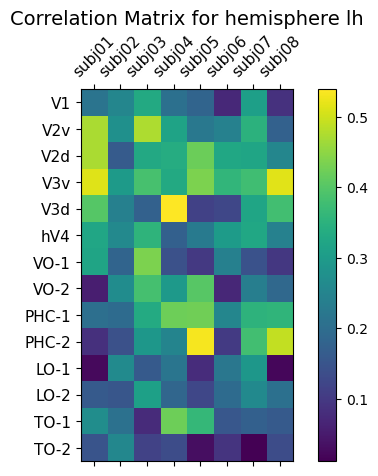

	kstest: KstestResult(statistic=0.6433632164706945, pvalue=1.111491576749535e-45, statistic_location=0.4902063995785145, statistic_sign=-1)
		correlations do not follow a normal distribution
			wilcoxon: WilcoxonResult(statistic=6327.0, pvalue=2.1327349655435884e-20)
Sample mean is significantly greater than 0


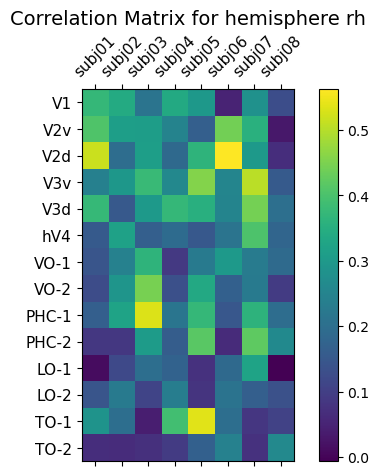

In [14]:

### load distances file
distances_file = os.path.join(spatial_dir, f'distances_spearman_joined_{model}.npy')

distances = np.load(distances_file, allow_pickle=True)
distances = pd.DataFrame(distances, columns=columns)
distances = distances.astype({c: t for c,t in zip(columns, types)})



for hemi in hemis:
    f = plt.figure()
    df = distances.loc[distances.hemisphere == hemi][["subject", "roi", "spearmanr"]]
    df = df.pivot_table(values='spearmanr', columns='subject', index='roi')
    df = df.reindex(list(rois_corr.keys()))
    plt.matshow(df, fignum =  f.number) #change the range 
    plt.xticks(range(len(df.columns)), df.columns, fontsize=11, rotation=45)
    plt.yticks(range(len(df.index)), df.index, fontsize=11)
    cb = plt.colorbar()
    cb.ax.tick_params()
    plt.title(f'Correlation Matrix for hemisphere {hemi}', fontsize=14);
    
    correlations = df.to_numpy().flatten()
    correlations_normalized = correlations - correlations.mean()
    correlations_normalized = correlations / correlations.std()
    ks_res = sc.stats.kstest(correlations_normalized, sc.stats.norm.cdf)
    print(f'\tkstest: {ks_res}')
    notnormal = ks_res.pvalue < significance
    if notnormal:
        print('\t\tcorrelations do not follow a normal distribution')
        # do wilcox signed rank test
        res = sc.stats.wilcoxon(
            correlations, 
            y = None,
            zero_method = 'zsplit', 
            nan_policy = 'raise',
            correction = True,
            method = 'approx',
            alternative = 'greater'
        )
        print(f'\t\t\twilcoxon: {res }')
    else:
        print('\t\tcorrelations follow a normal distribution')
        res = sc.stats.ttest_1samp(correlations, popmean=0, alternative = 'greater')
        # should adjust with upscaling factor
        print(f'\t\t\tttest: {res}')
    if res.pvalue < significance:
        print('Sample mean is significantly greater than 0')
    else:
        print('Sample mean is NOT significantly greater than 0')
   # plt.savefig(f'correlation_{hemi}.png', bbox_inches='tight')
    plt.show();
    
    

In [103]:
# Save for matlab

lh_df = distances[distances['hemisphere'] == 'lh']
rh_df = distances[distances['hemisphere'] == 'rh']
lh_df_pivot = lh_df.pivot(index='subject', columns='roi', values='spearmanr')
rh_df_pivot = rh_df.pivot(index='subject', columns='roi', values='spearmanr')
lh_df_pivot
#lh_df_pivot.to_csv('lh_spearman_rho_oself.csv', index=True)
#rh_df_pivot.to_csv('rh_spearman_rho_oself.csv', index=True)

roi,LO-1,LO-2,PHC-1,PHC-2,TO-1,TO-2,V1,V2d,V2v,V3d,V3v,VO-1,VO-2,hV4
subject,,,,,,,,,,,,,,
subj01,0.025756,0.160501,0.204325,0.084898,0.271112,0.148594,0.213987,0.473202,0.471681,0.399819,0.514150,0.319668,0.054958,0.323254
subj02,0.263732,0.152345,0.195961,0.141712,0.209111,0.256001,0.254470,0.163620,0.275708,0.241559,0.299288,0.181908,0.268558,0.259877
subj03,0.161129,0.311444,0.333510,0.291089,0.076325,0.116081,0.332873,0.329240,0.474827,0.175437,0.386314,0.435234,0.382589,0.354471
subj04,0.216566,0.186447,0.422096,0.249074,0.423434,0.134025,0.206347,0.339029,0.318114,0.539160,0.331657,0.143482,0.295026,0.174265
subj05,0.077850,0.123279,0.424002,0.532619,0.363067,0.031977,0.182501,0.420925,0.221888,0.113027,0.434829,0.099570,0.402447,0.228687
subj06,0.220748,0.195839,0.253715,0.101161,0.155503,0.091763,0.072946,0.326071,0.243727,0.124304,0.357995,0.241751,0.069792,0.301006
subj07,0.290663,0.262401,0.351903,0.379984,0.173219,0.011655,0.309232,0.322151,0.350215,0.320742,0.377886,0.145050,0.237624,0.326609
subj08,0.021331,0.206571,0.357515,0.491049,0.161174,0.134581,0.086224,0.253738,0.174975,0.378656,0.515397,0.097221,0.190353,0.242904
